In [4]:
import deconV as dv

import torch
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
reference_file = "../../data/xin/sc.tsv"
reference_mdata_file = "../../data/xin/pdata.tsv"
bulk_file = "../../data/xin/bulk.tsv"
cell_types = ["alpha", "delta", "gamma", "beta"]

sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white')
sc.settings.figdir = "../deconV/figures/"

### 1. Read data + basic QC

In [6]:
sadata = dv.tl.read_data(reference_file)

pheno_df = pd.read_csv(reference_mdata_file, sep="\t", index_col=0)
pheno_df.index.name = None
common_cells = list(set(pheno_df.index.tolist()) & set(sadata.obs_names.tolist()))

sadata = sadata[common_cells, :].copy()
pheno_df = pheno_df.loc[common_cells, :].copy()
sadata.obs["labels"] = pheno_df["cellType"].tolist()
sadata.obs["labels"] = sadata.obs["labels"].astype("category")

sadata = sadata[sadata.obs["labels"].astype("str").isin(cell_types), :].copy()

print(sadata.obs.groupby("labels").size())

bulk_df = pd.read_csv(bulk_file, sep="\t", index_col=None)
if bulk_df.iloc[:,0].dtype == "O":
    bulk_df.set_index(bulk_df.columns[0], inplace=True)
print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")

sc.pp.filter_cells(sadata, min_genes=200)
sc.pp.filter_genes(sadata, min_counts=100)

labels
alpha    443
beta     171
delta     59
gamma     75
dtype: int64
bulk RNA-seq data - samples: 18, genes: 39849


### 2. Combine single-cell and bulk into same AnnData object

In [7]:
adata = dv.tl.combine(sadata, bulk_df)
del sadata

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=None)
adata.layers["ncounts"] = adata.X.copy()
sc.pp.log1p(adata)

# sc.pp.highly_variable_genes(adata, n_top_genes=10000, subset=True)
adata.obsm["lib_size"] = adata.layers["counts"].sum(1)
adata.shape

scRNA-seq data - cells: 748, genes: 15029
bulk RNA-seq data - samples: 18, genes: 15029


(748, 15029)

### 3. Choose device to run on

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 4. Initialize model

In [9]:
decon = dv.DeconV(
    adata, cell_type_key="labels",  # cell_type_key is the column key in adata.obs that holds the cell type annotations 
    dropout_type="separate",        # separate, shared, or None
    model_type="gamma",             # Gamma, Beta, nb, lognormal, or static    
    device=device
)

### 5. Train the reference model

In [10]:
decon.fit_reference(num_epochs=2000, lr=0.1, lrd=0.999, layer="counts")

Rounding counts to integers.


100%|██████████| 2000/2000 [00:42<00:00, 47.46it/s, loss=3.68e+05, lr=1.35e-02]


### 6. Deconvolute

In [11]:
proportions = decon.deconvolute(model_dropout=True, lrd=0.999, lr=0.1, num_epochs=1000)

100%|██████████| 1000/1000 [00:05<00:00, 180.25it/s, loss=3.42e+09, lr=3.68e-02]


In [33]:
proportions_df = pd.DataFrame(proportions.cpu().numpy(), index=adata.uns["bulk_samples"], columns=decon.cell_types)
proportions_df

,alpha,beta,delta,gamma
D6,0.656677,0.313256,0.009650,0.020417
D5,0.905695,0.086459,0.005718,0.002129
D4,0.602218,0.377635,0.010282,0.009866
D3,0.506029,0.340698,0.021851,0.131423
D2,0.670359,0.186083,0.038150,0.105408
D1,0.403685,0.172285,0.020863,0.403167
H12,0.658877,0.333012,0.007855,0.000257
H11,0.669749,0.259078,0.012657,0.058516
H10,0.562853,0.396320,0.040455,0.000371
H9,0.661050,0.152345,0.002944,0.183661


### 7. Visualize results

In [44]:
df = decon.get_results_df()
df

,sample,cell_type,est,min,max
0,D6,alpha,0.656677,0.056583,0.053170
1,D5,alpha,0.905695,0.022010,0.019974
2,D4,alpha,0.602218,0.062339,0.060994
3,D3,alpha,0.506029,0.057902,0.057394
4,D2,alpha,0.670359,0.049700,0.047383
...,...,...,...,...,...
67,H5,gamma,0.047040,0.028441,0.039932
68,H4,gamma,0.188042,0.058322,0.066350
69,H3,gamma,0.056514,0.022112,0.027274
70,H2,gamma,0.204269,0.035920,0.039635


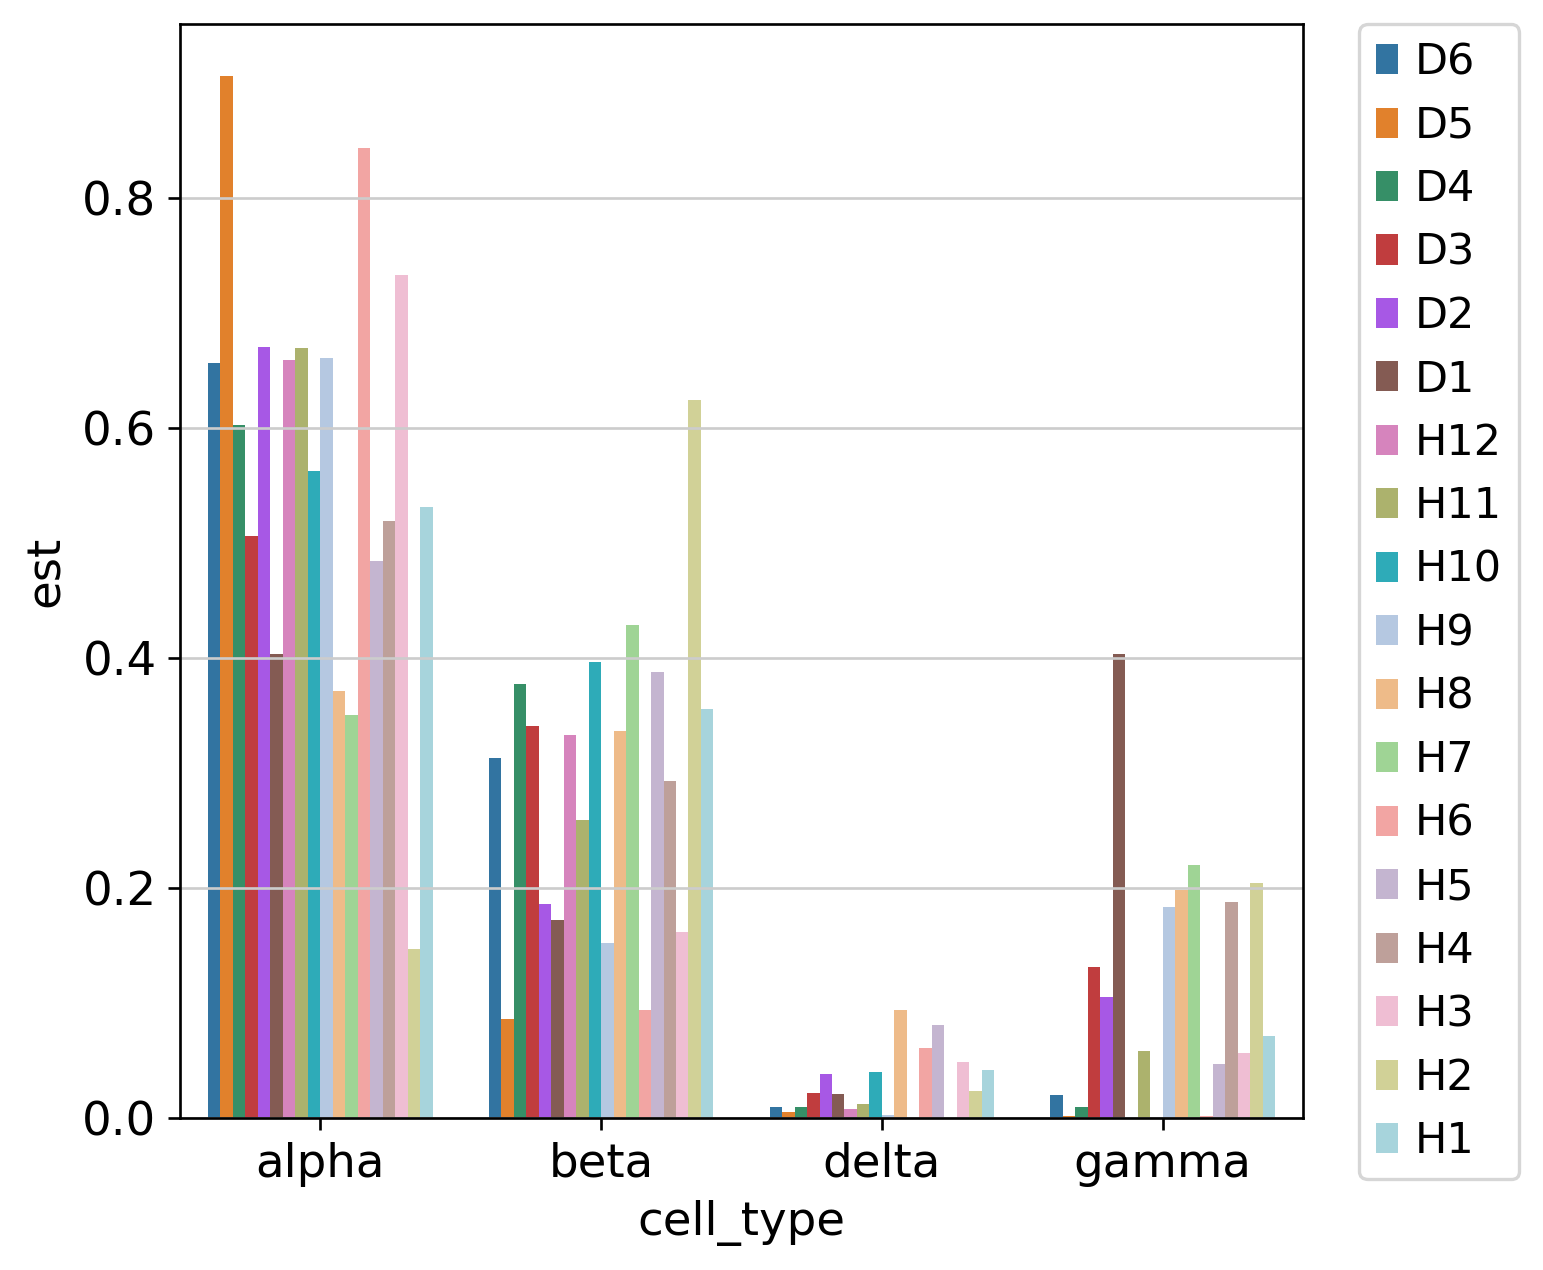

In [45]:
f, ax = plt.subplots(figsize=(6,6), dpi=120)

sns.barplot(
    data=df, x="cell_type", y="est", hue="sample", ax=ax
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<AxesSubplot: xlabel='cell_type', ylabel='est'>

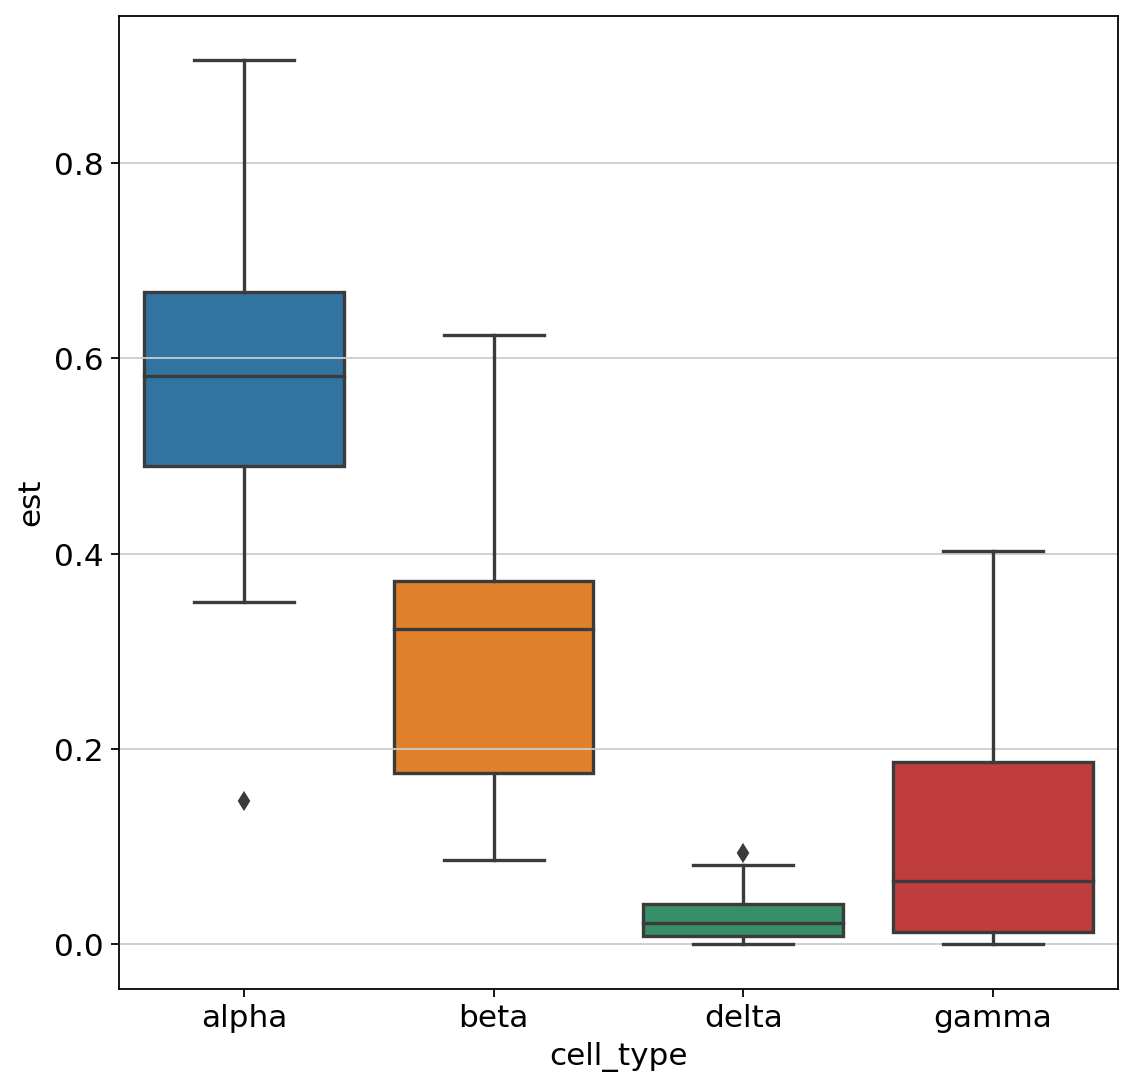

In [46]:
# Summarize proportions with boxplot
sns.boxplot(
    data=df, x="cell_type", y="est"
)

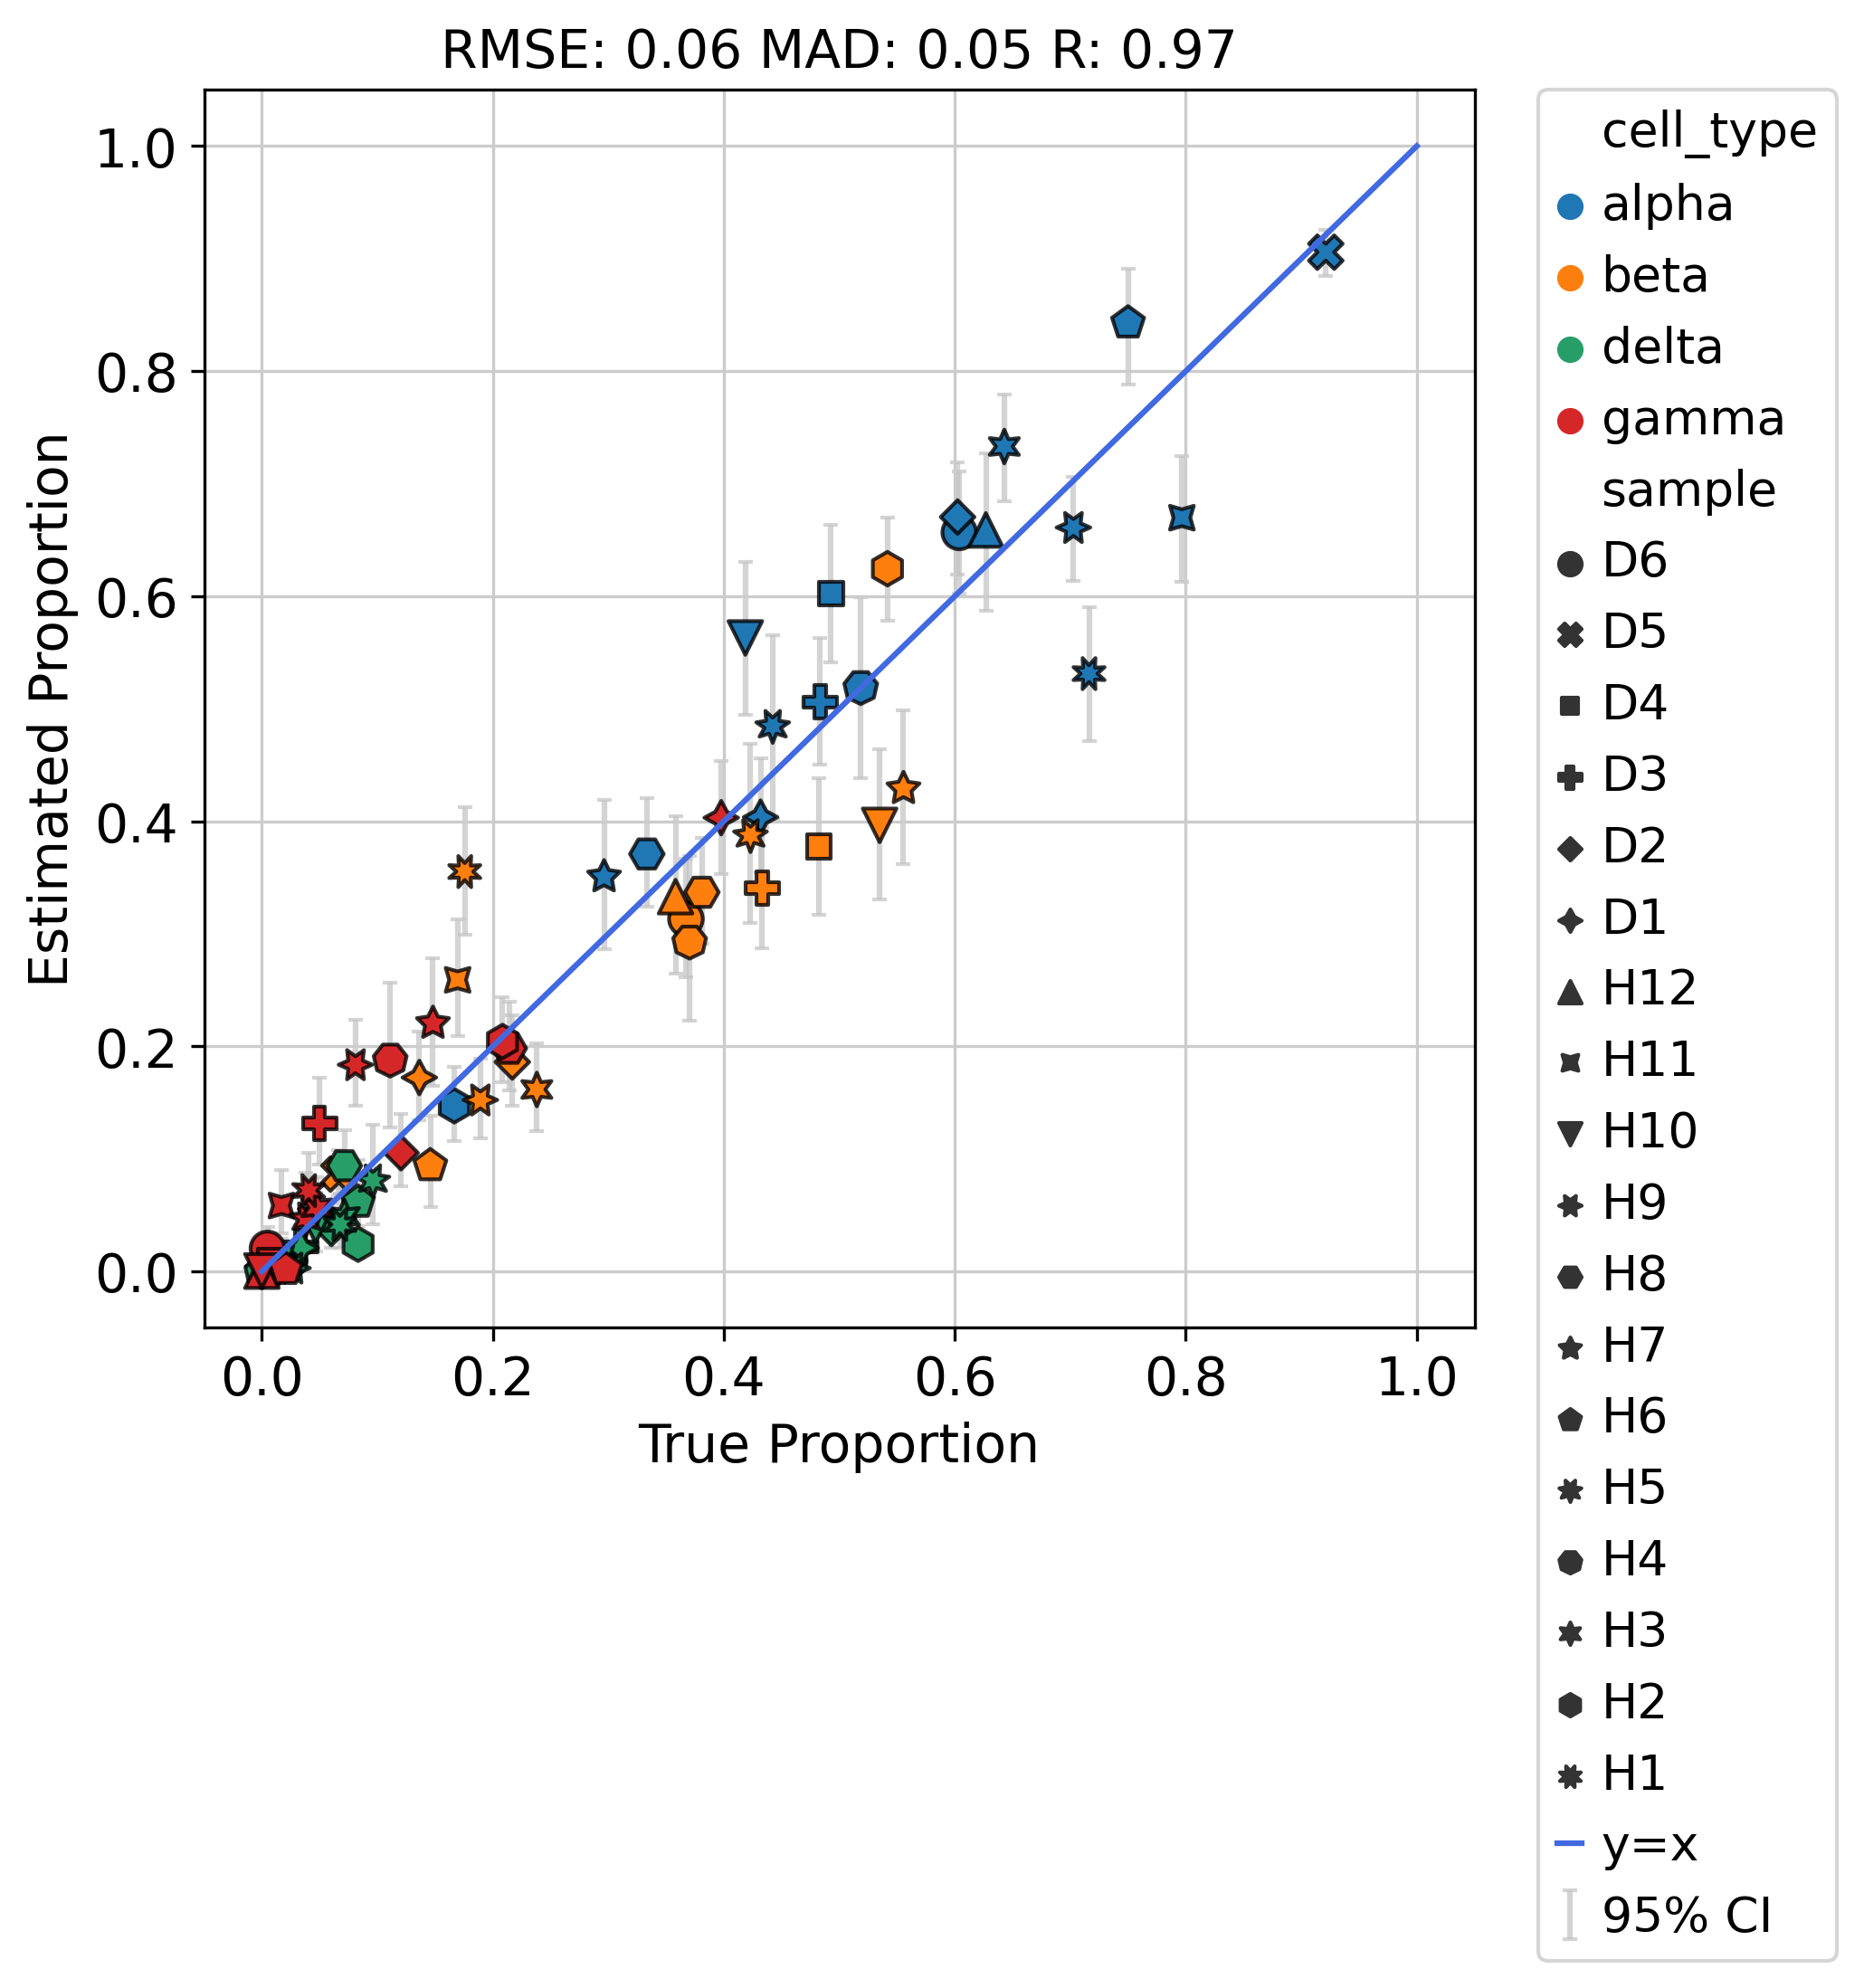

(0.06293370497477957, 0.045134441965378636, 0.9664158058966629)

In [12]:
# Ground truth proportions
true_df = pd.read_csv("../../data/xin/true.tsv", sep="\t", index_col=0)

res_df = decon.get_results_df()
res_df["true"] = true_df.melt()["value"]
dv.pl.xypredictions(res_df, figsize=(6,6), dpi=150)

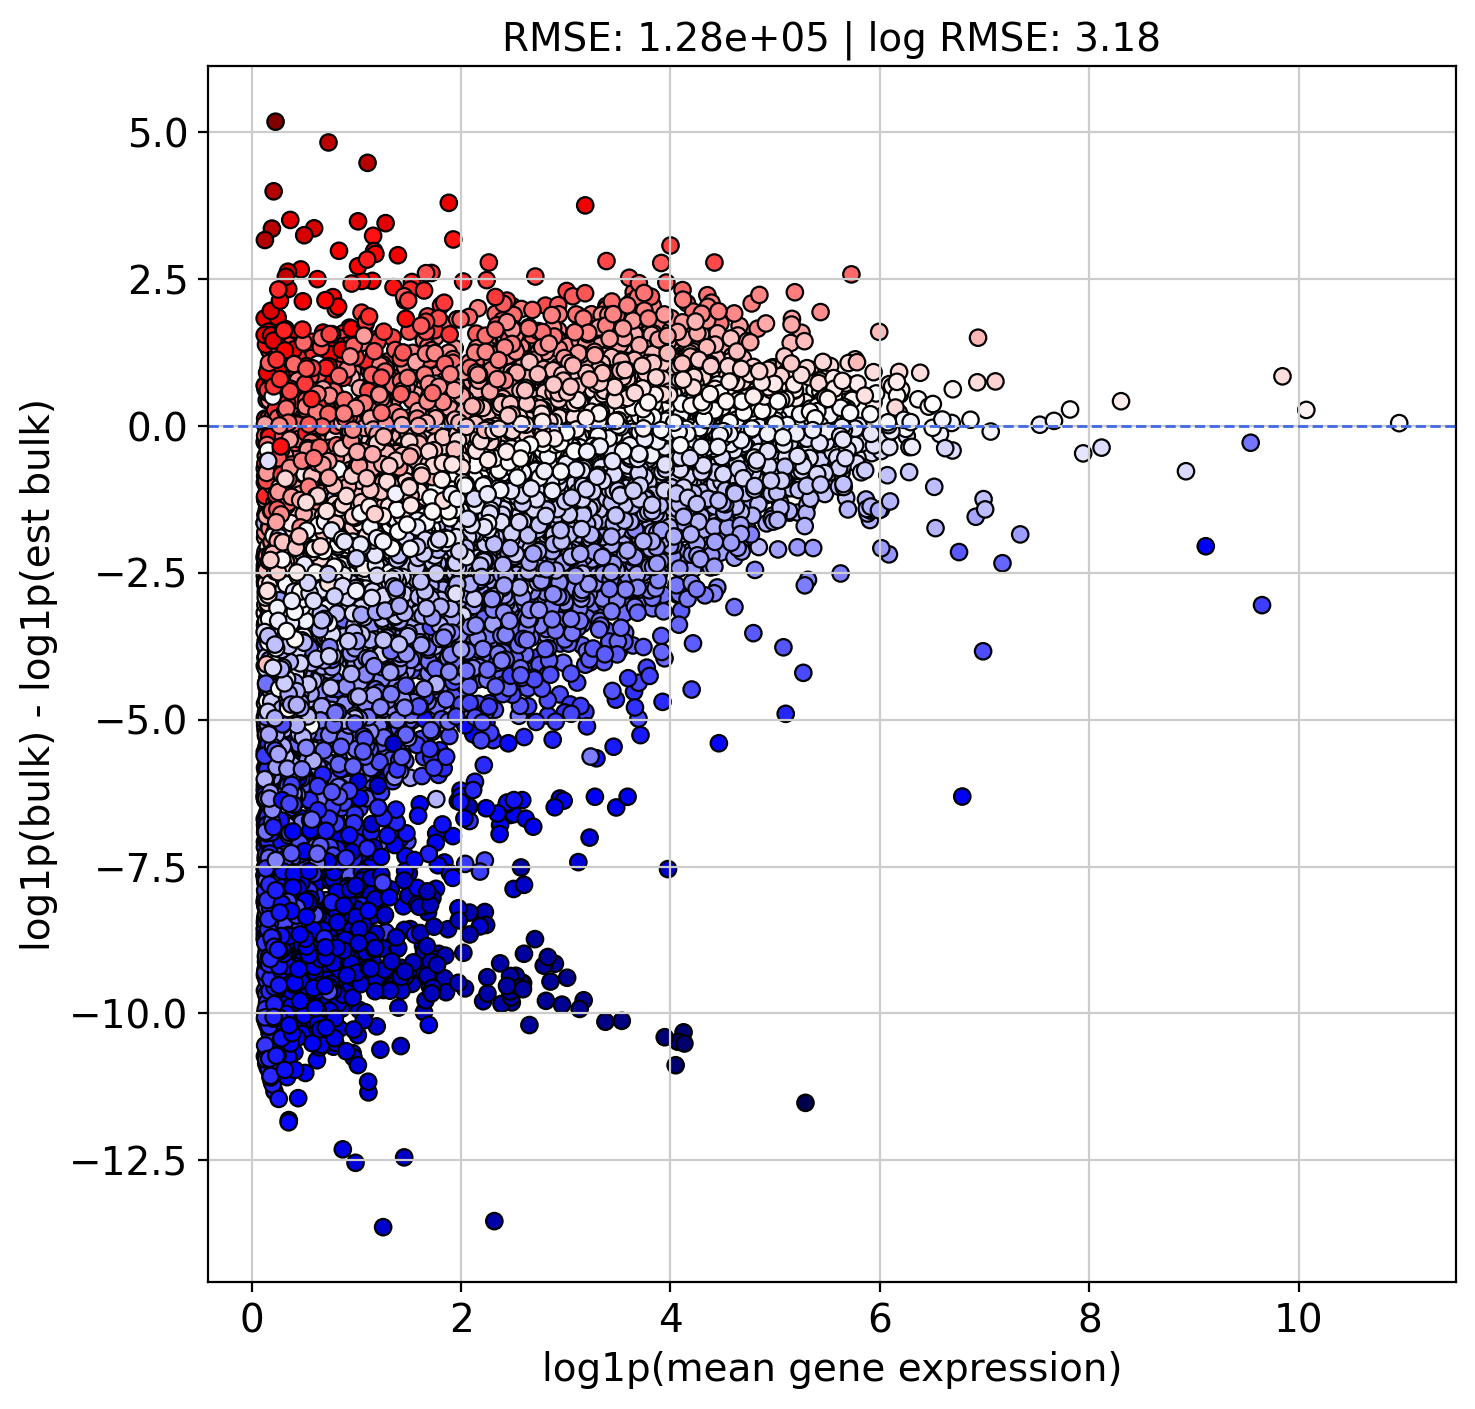

In [13]:
# Visualize objective function
dv.pl.prediction_plot(decon, 1)